In [103]:
# Attempt to plot Khumbu dataset
%matplotlib notebook

In [104]:
# Import modules - make sure you activated your rasterenv environment!
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from pygeotools.lib import iolib, warplib, geolib, timelib, malib

#### DEM sources:
32 m DEM derived from WorldView Stereo imagery acquired from 2003 to 2016

In [105]:
# Input DEM filenames
dem_2003_fn = '20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif'
dem_2012_fn = '20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_32m_trans.tif'
dem_2014_fn = '20141022_0518_1020010036518E00_102001003525D400-DEM_32m_trans.tif'
dem_2016_fn = '20161025_0524_104001002469AD00_1040010024438E00-DEM_32m_trans.tif'

dem_fn_list = [dem_2003_fn, dem_2014_fn, dem_2016_fn]

In [106]:
ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='intersection', res='min', t_srs=dem_2016_fn)


Warping all inputs to the following:
Resolution: 32.0
Extent: [483025.303, 3087761.676, 490835.841, 3094831.672]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 3: 20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif
nl: 221 ns: 244 res: 32.000
2 of 3: 20141022_0518_1020010036518E00_102001003525D400-DEM_32m_trans.tif
nl: 221 ns: 244 res: 32.000
3 of 3: 20161025_0524_104001002469AD00_1040010024438E00-DEM_32m_trans.tif
nl: 221 ns: 244 res: 32.000


In [107]:
# Load datasets to NumPy masked arrays
dem_2003, dem_2014, dem_2016 = [iolib.ds_getma(i) for i in ds_list]
dem_list = [dem_2003, dem_2014, dem_2016]

In [108]:
print(dem_2014.shape)
print(dem_2014.dtype)

(221, 244)
float32


In [109]:
dem_2014 # check out that the masked values were noted in a mask layer from the iolib thing

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 4998.255859375, 4996.1240234375,
         5004.39501953125],
        [--, --, --, ..., 4989.328125, 4984.91796875, 4992.2021484375],
        [--, --, --, ..., 4983.916015625, 4981.494140625,
         4982.77783203125]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=0.0,
  dtype=float32)

In [110]:
# generate 3 panel plot for input arrays
#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(adjustable='box-forced', aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

<IPython.core.display.Javascript object>


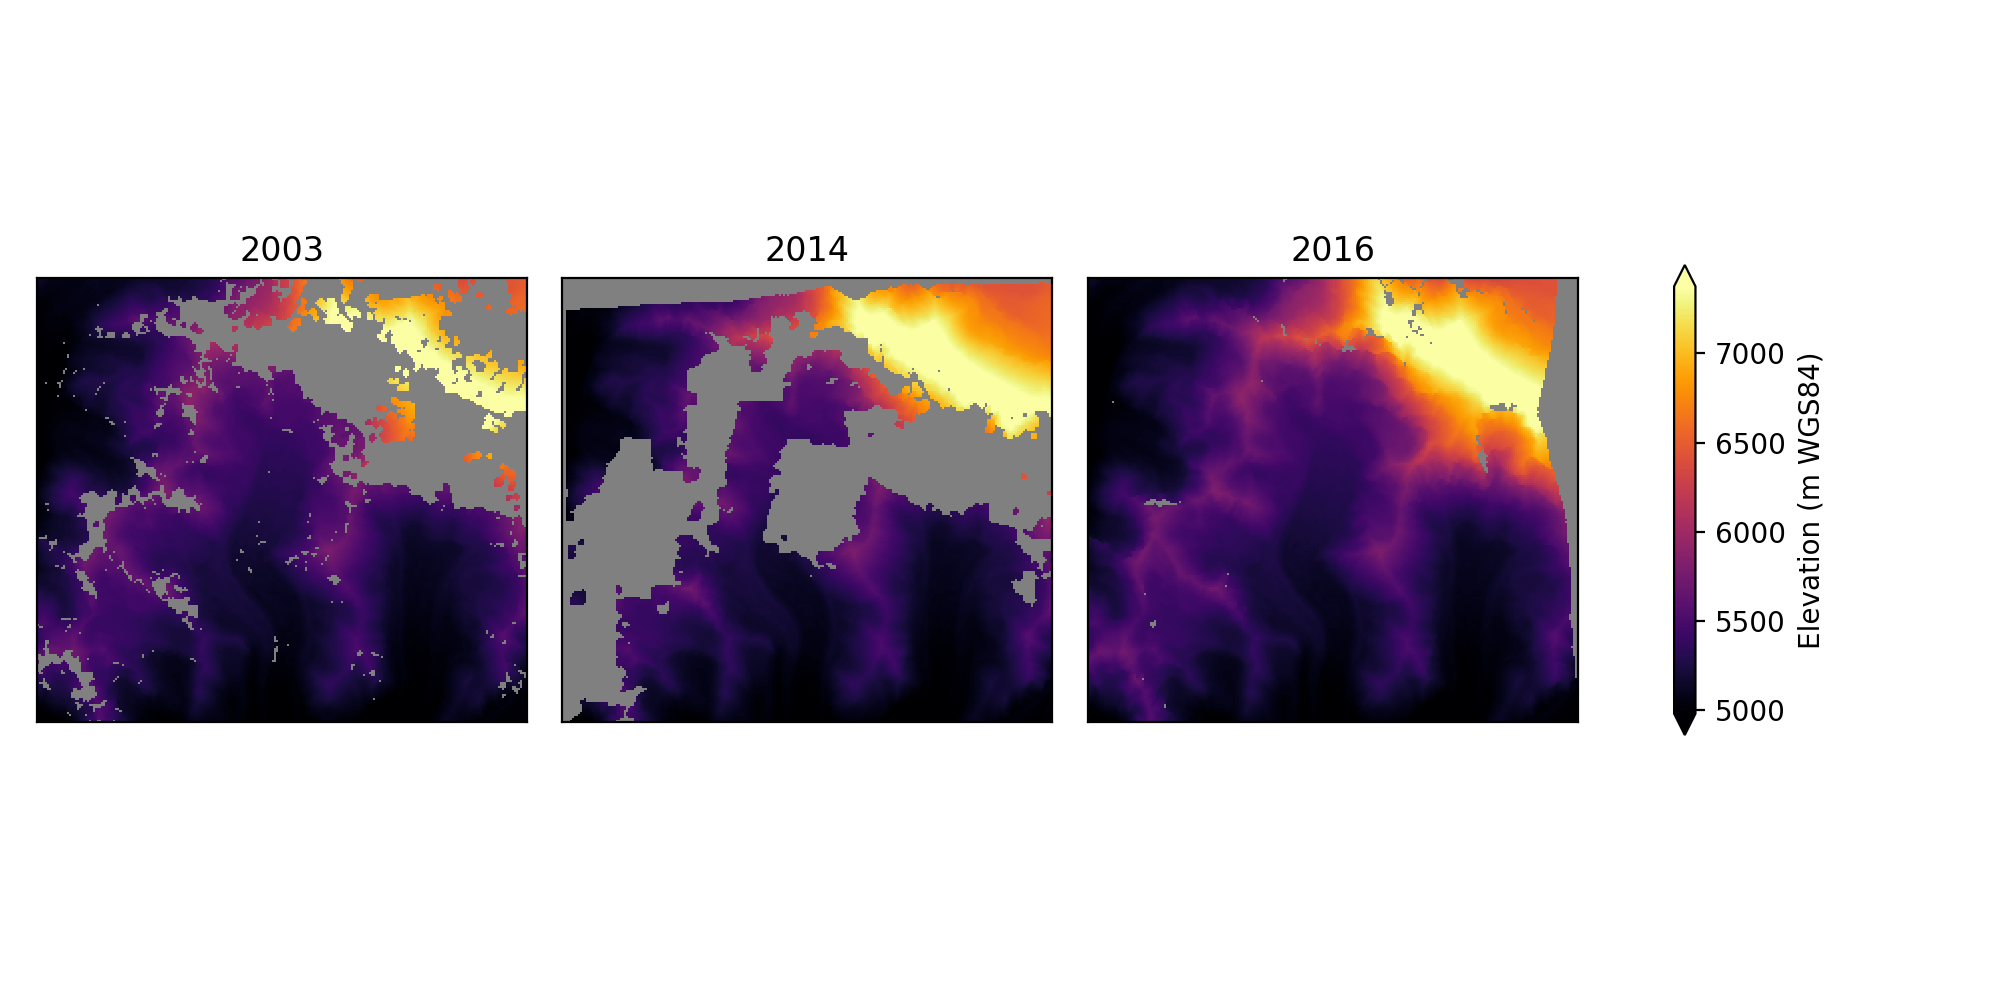

/anaconda3/envs/rasterenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


In [111]:
titles = ['2003', '2014', '2016']
clim = malib.calcperc(dem_list[0], (2,98))
plot3panel(dem_list, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

<IPython.core.display.Javascript object>


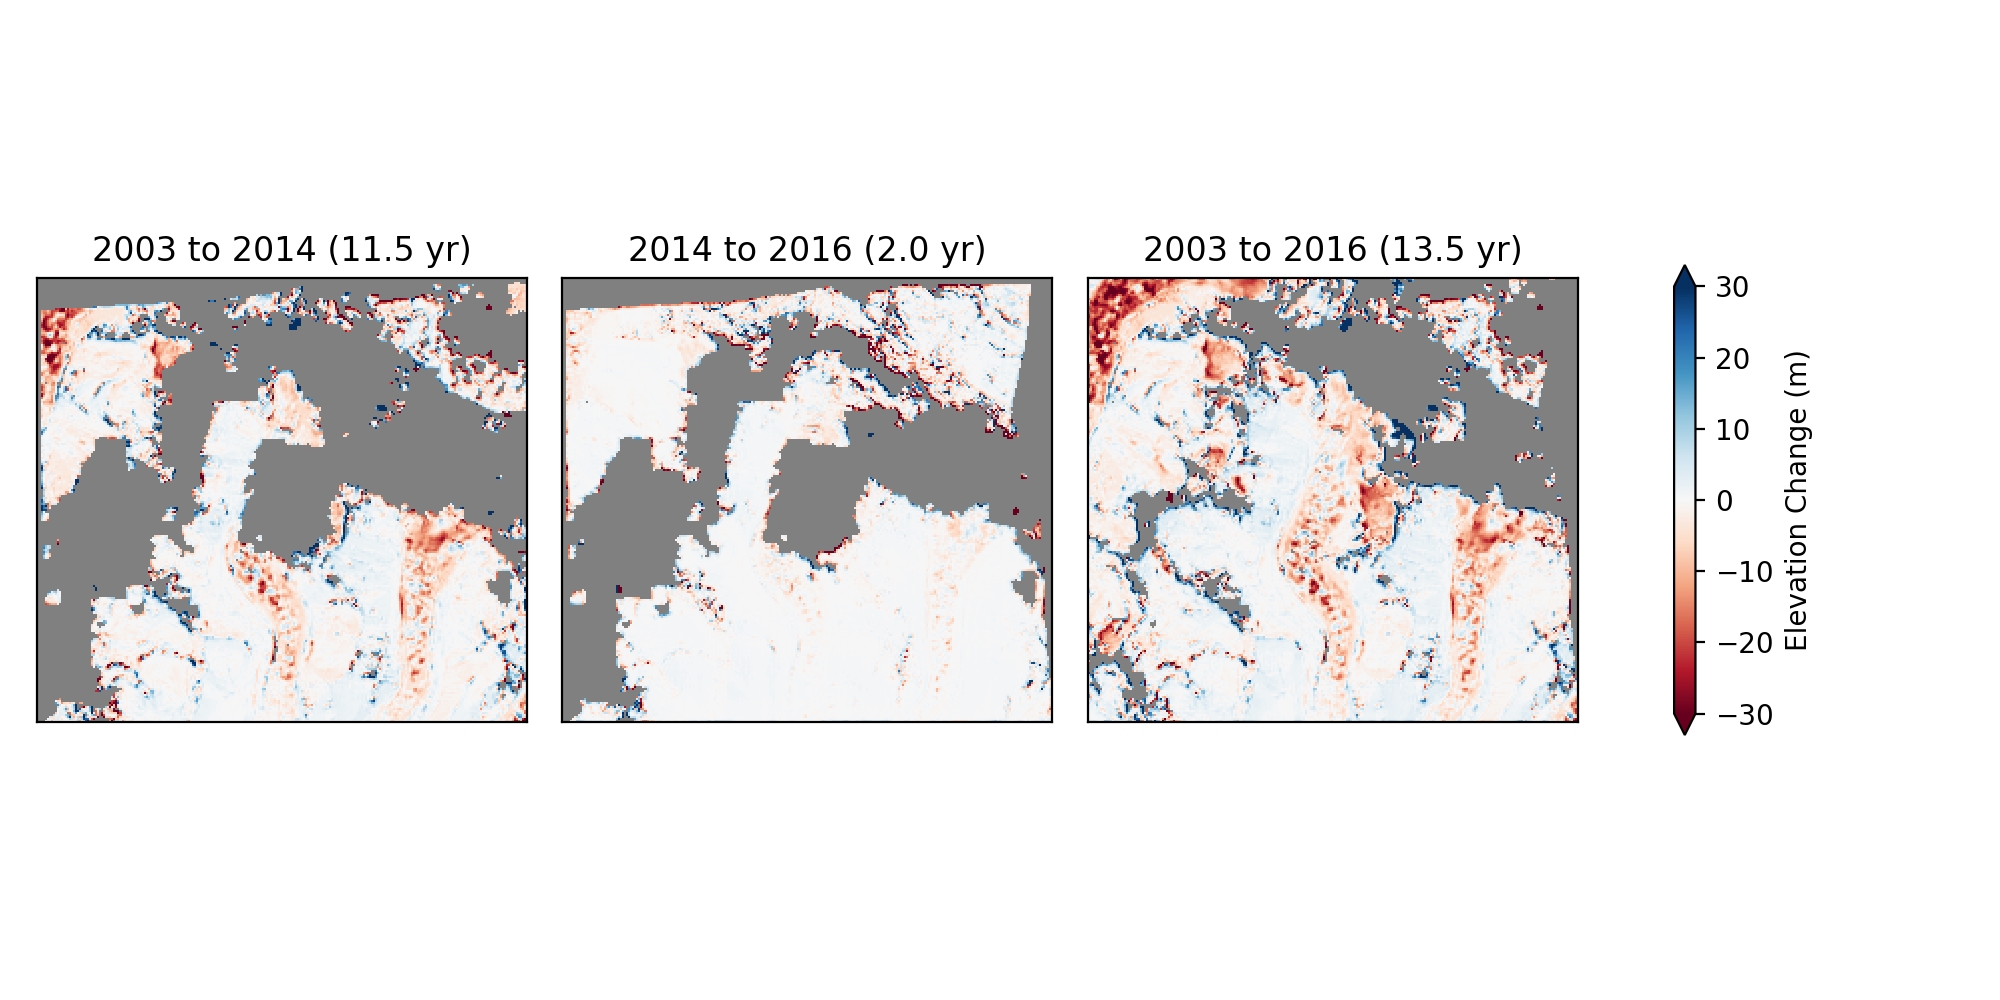

/anaconda3/envs/rasterenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


In [114]:
#Calculate elevation difference for each time period
#In this case, we will store the difference maps in a list for convenience
dh_list = [dem_2014 - dem_2003, dem_2016 - dem_2014, dem_2016 - dem_2003]

#Let's extract timestamps from filenames
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
#Now let's compute total time between observations in decimal years
#Compute time differences, convert decimal years
dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]
#Add the full 1970-2015 time difference
dt_list.append(dt_list[0]+dt_list[1])

#Now plot the elevation differences 
titles = ['2003 to 2014 (%0.1f yr)' % dt_list[0], '2014 to 2016 (%0.1f yr)' % dt_list[1], '2003 to 2016 (%0.1f yr)' % dt_list[2]]
plot3panel(dh_list, (-30, 30), titles, 'RdBu', 'Elevation Change (m)', fn='dem_dh.png')


<IPython.core.display.Javascript object>


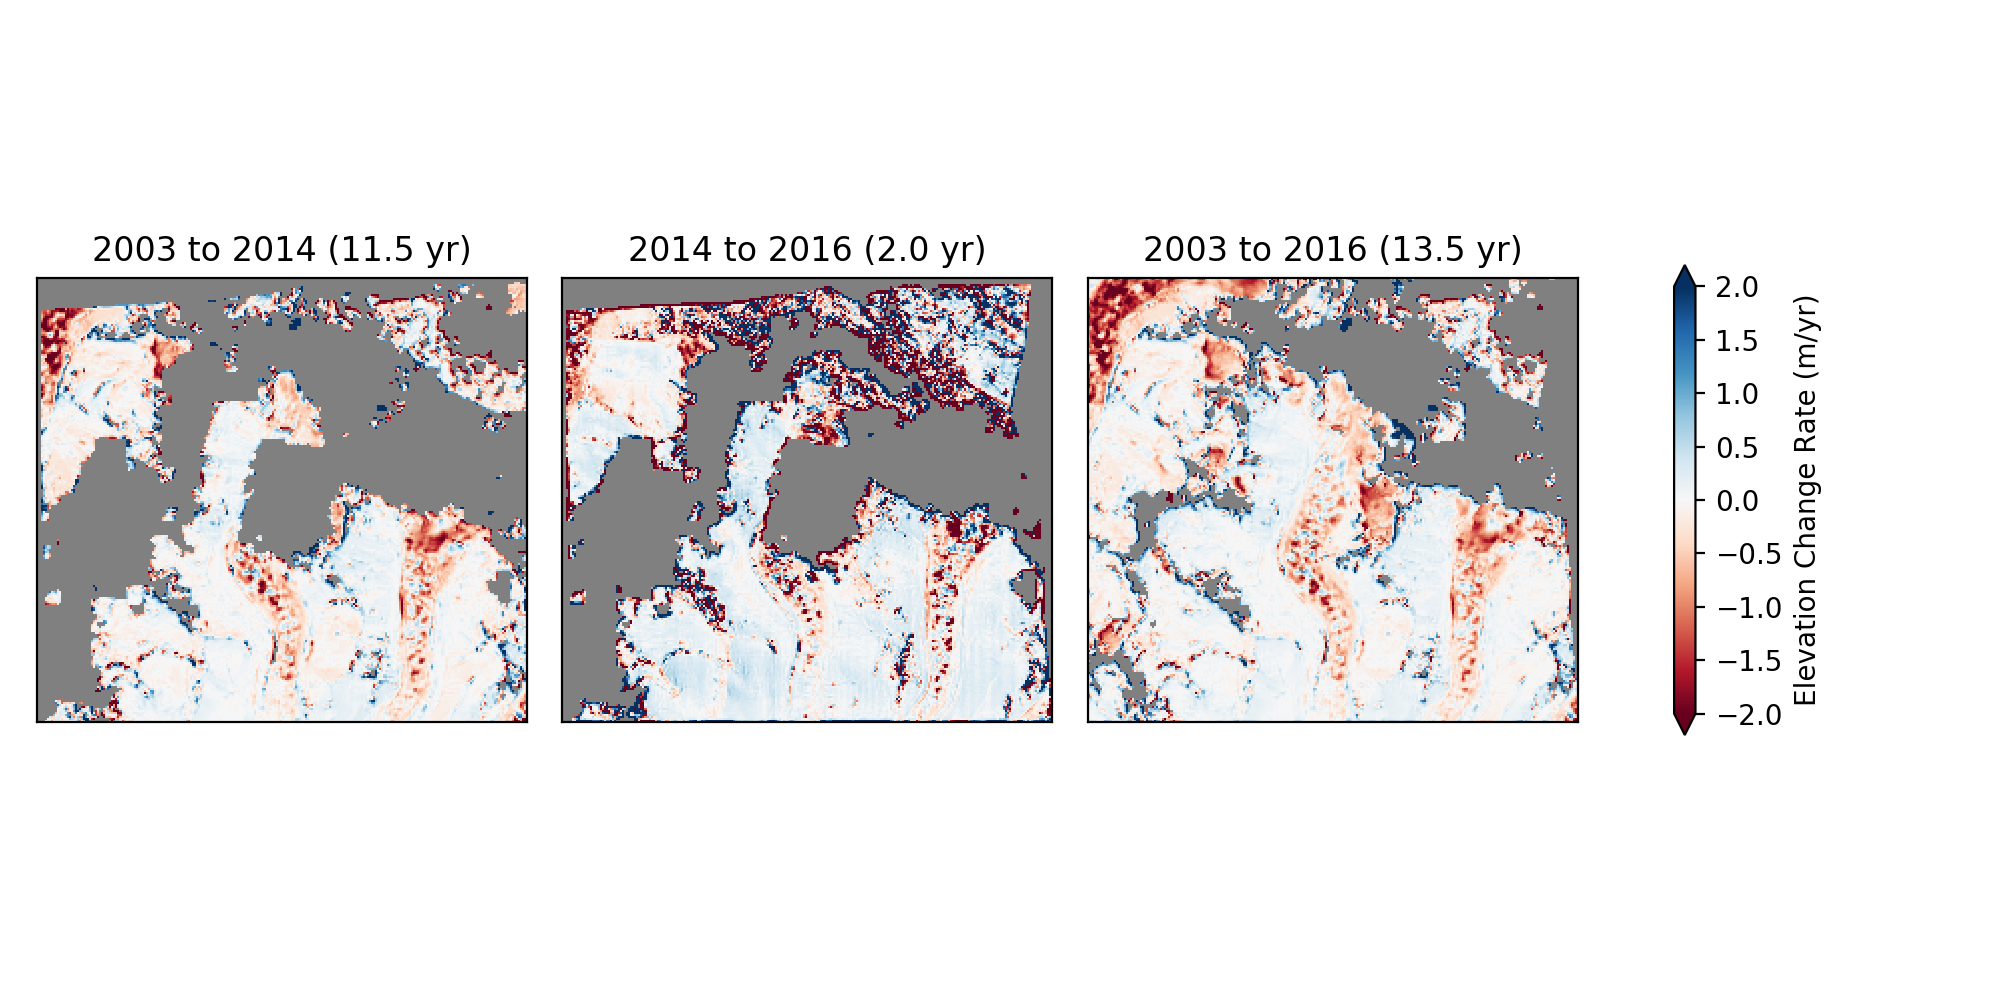

/anaconda3/envs/rasterenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


In [115]:
#Calculate annual rate of change
dhdt_list = np.ma.array(dh_list)/np.array(dt_list)[:,np.newaxis,np.newaxis]
plot3panel(dhdt_list, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)', fn='dem_dhdt.png')

In [117]:
# NOTE this is commented out because there is no shapefile pre-created for our khumbu glacier

# shp_fn = 'data/rainier/rgi60_glacierpoly_rainier.shp'
# #Create binary mask from polygon shapefile to match our warped raster datasets
# shp_mask = geolib.shp2array(shp_fn, ds_list[0])
# #Now apply the mask to each array 
# dhdt_list_shpclip = [np.ma.array(dhdt, mask=shp_mask) for dhdt in dhdt_list]
# plot3panel(dhdt_list_shpclip, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)', fn='dem_dhdt_shpclip.png')

<IPython.core.display.Javascript object>


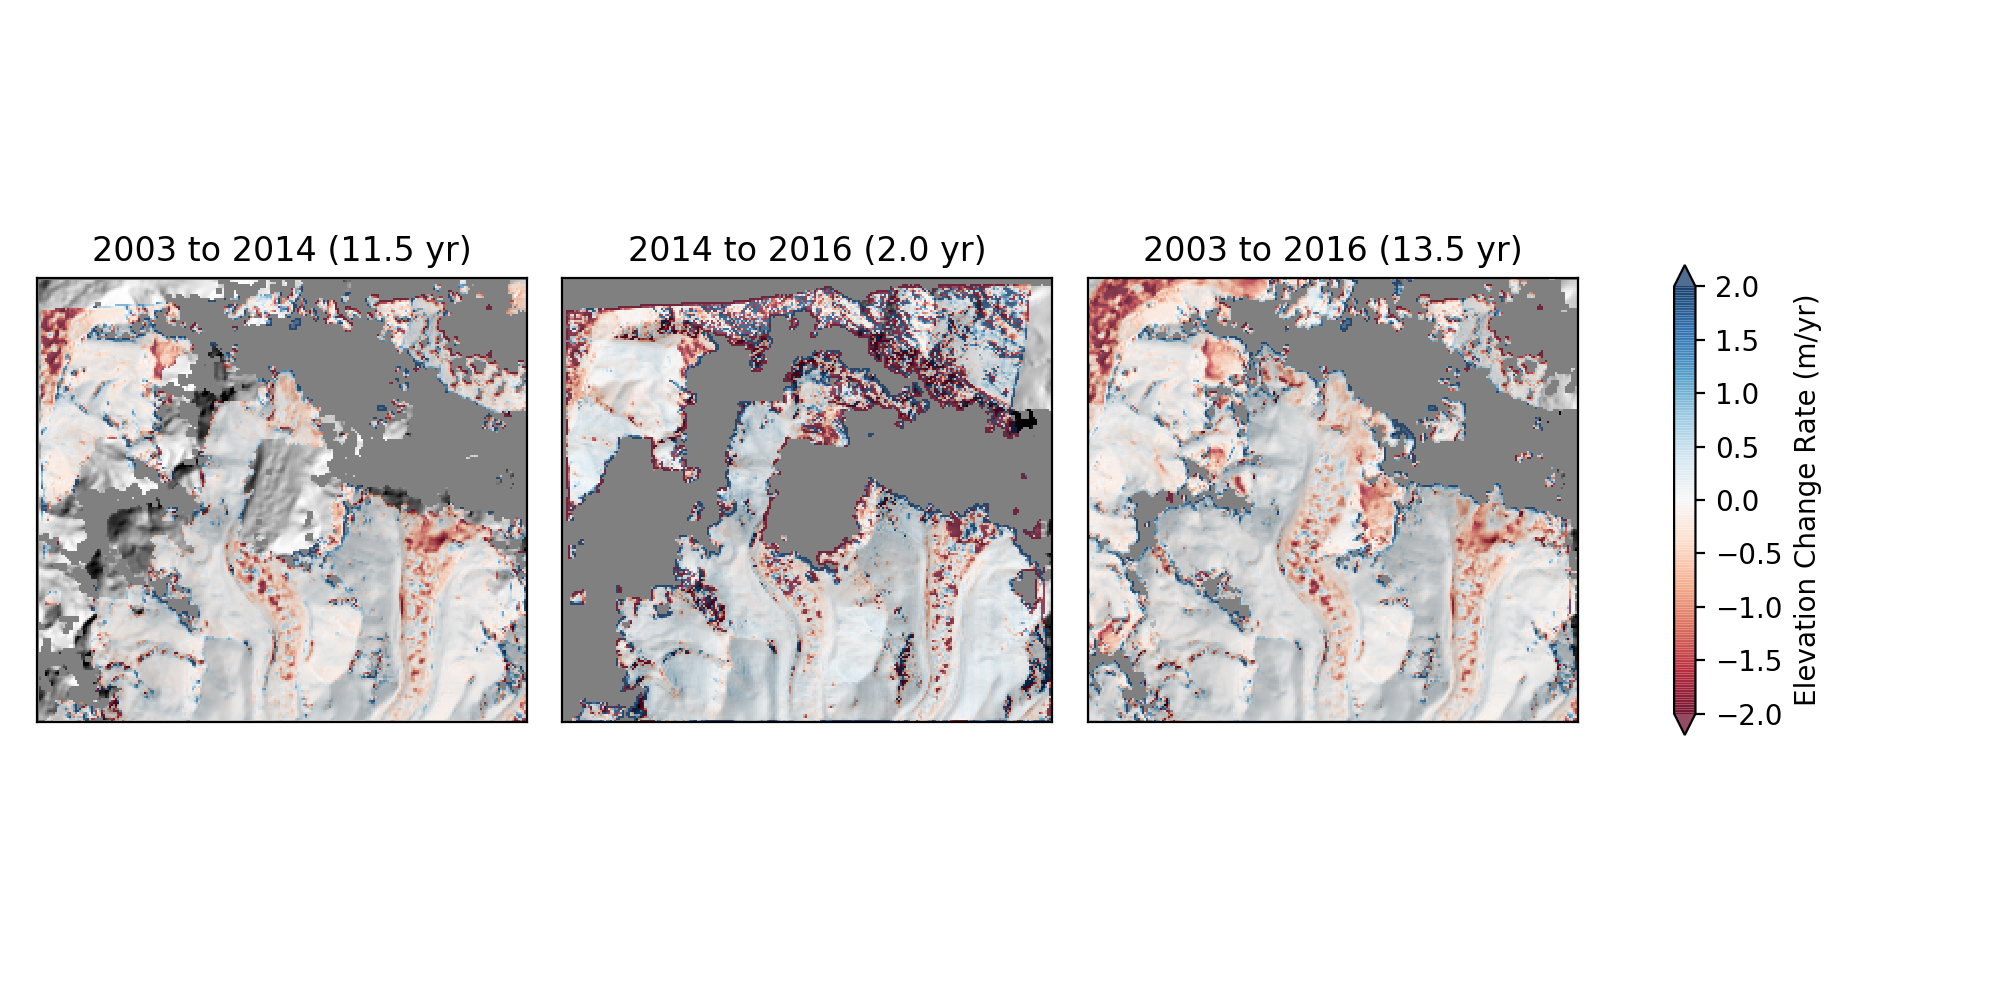

/anaconda3/envs/rasterenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


In [120]:
dem_2003_hs_ds = gdal.DEMProcessing('', ds_list[0], 'hillshade', format='MEM')
dem_2003_hs = iolib.ds_getma(dem_2003_hs_ds)
dem_2014_hs_ds = gdal.DEMProcessing('', ds_list[1], 'hillshade', format='MEM')
dem_2014_hs = iolib.ds_getma(dem_2014_hs_ds)
hs_list = [dem_2003_hs, dem_2014_hs, dem_2003_hs]

#Plot our rates over shaded relief maps
plot3panel(dhdt_list, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)', overlay=hs_list, fn='dem_dhdt_shpclip_hs.png')

In [125]:
#Extract x and y pixel resolution (m) from geotransform
gt = ds_list[0].GetGeoTransform()
px_res = (gt[1], -gt[5])
#Calculate pixel area in m^2
px_area = px_res[0]*px_res[0]
# dhdt_list_shpclip = np.ma.array(dhdt_list_shpclip).reshape(len(dhdt_list_shpclip), dhdt_list_shpclip[0].shape[0]*dhdt_list_shpclip[1].shape[1])

1024.0


In [134]:
#Now, lets multiple pixel area by the observed elevation change for all valid pixels over glaciers
dhdt_mean = dhdt_list.mean(axis=1)
#Compute area in km^2
area_total = px_area * dhdt_list.count(axis=1) / 1E6
#Volume change rate in km^3/yr
vol_rate = dhdt_mean * area_total / 1E3

print(type(vol_rate))
print(type(area_total))
print(type(dt_list))

# #Volume change in km^3
vol_total = vol_rate * dt_list 
# #Assume intermediate density between ice and snow for volume change (Gt)
# rho = 0.850
# mass_rate = vol_rate * rho
# mass_total = vol_total * rho

# #Print some numbers (clean this up)
# out = zip(titles, dhdt_mean, area_total, vol_rate, vol_total, mass_rate, mass_total)
# for i in out:
#     print(i[0])
#     print('%0.2f m/yr mean elevation change rate' % i[1])
#     print('%0.2f km^2 total area' % i[2])
#     print('%0.2f km^3/yr mean volume change rate' % i[3])
#     print('%0.2f km^3 total volume change' % i[4])
#     print('%0.2f Gt/yr mean mass change rate' % i[5])
#     print('%0.2f Gt total mass change\n' % i[6])

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ndarray'>
<class 'list'>


ValueError: operands could not be broadcast together with shapes (3,244) (3,) 